In [83]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


Requested tensorflow-gpu from https://files.pythonhosted.org/packages/8a/45/fa31ced1db38f9424f262dfbf35747fe5378b5c808cecb373c8cb8e515d3/tensorflow-gpu-2.12.0.tar.gz has invalid metadata: Expected end or semicolon (after name and no valid version specifier)
    python_version>"3.7"
                  ^
Please use pip<24.1 if you need to use this version.
ERROR: Could not find a version that satisfies the requirement tensorflow-gpu (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu


Importing Dependencies and Setup

In [84]:
import tensorflow as tf
import os #Navigate through file structures 

In [85]:
#Avoid OOM (Out Of Memory) errors that consume all the VRAM in GPUS
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: #For each gpu in the system, dont use all the VRAM
    tf.config.experimental.set_memory_growth(gpu, True)

Remove Dodgy Images

In [86]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [87]:
#Remove images with incorrect extensions, or corrupt images
import cv2 
import imghdr

In [88]:
data_dir = 'Google Images'

In [89]:
os.listdir(data_dir) #List the contents of the data directory

['Happy', 'Sad']

In [90]:
happy_images = os.listdir(os.path.join(data_dir, 'Happy')) #List the contents of the happy directory (subdirectory of data_dir)


In [91]:
image_exts = ['jpeg', 'jpg', 'png', 'bmp'] #Valid image extensions

In [92]:
for image_class in os.listdir(data_dir):
    print(image_class) #Print the name of the image class (subdirectory of data_dir)

Happy
Sad


In [93]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path) #This shows how many pixels are in the image as well as the color channels 
            tip = imghdr.what(image_path) #Get the image type (extension)
            if tip not in image_exts: #If the image type is not in the list of valid image extensions
                os.remove(image_path) #Remove the image
                print(f"Removed {image_path} - Invalid extension")
        except Exception as e:
            os.remove(image_path)
            print(f"Removed {image_path} - {e}")

Load Data 

In [94]:
import numpy as np
import matplotlib.pyplot as plt

In [95]:
#Load the data
data = tf.keras.utils.image_dataset_from_directory(data_dir) #Load the data from the directory

Found 138 files belonging to 2 classes.


In [96]:
data_iterator = data.as_numpy_iterator() #Convert the data to a numpy iterator so that we can access the data in batches

In [97]:
batch = data_iterator.next() #Get the next batch of data from the iterator

In [98]:
len(batch) #The first element of the batch is the images, the second element is the labels

2

In [99]:
batch[1] #1 represents sad, 0 represents happy

array([0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [100]:
batch[0].max() #The first element of the batch is the images, the second element is the labels
#Scale this to 0-1 by dividing by 255

255.0

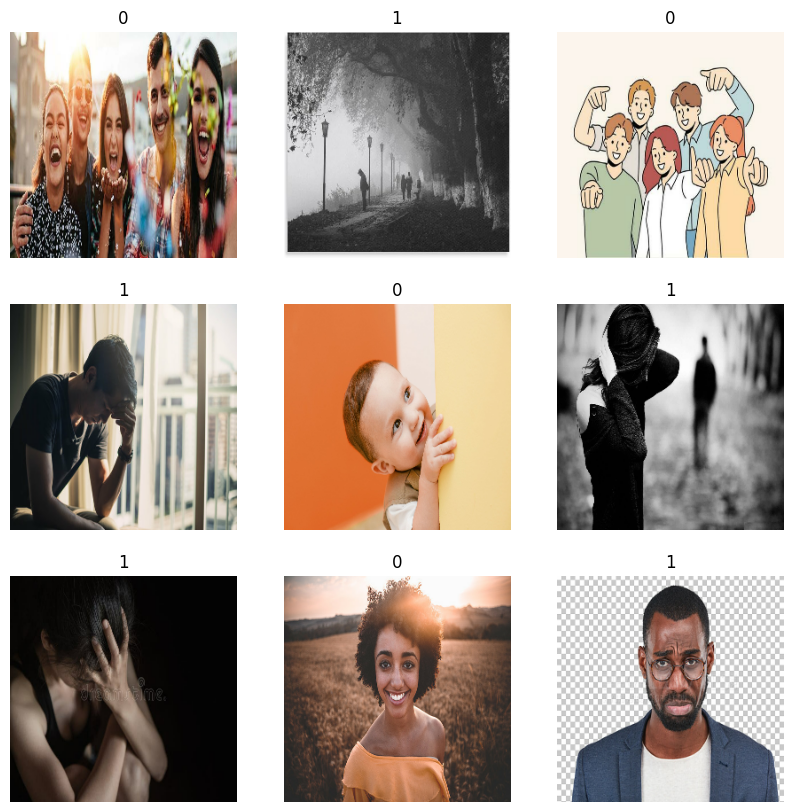

In [101]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10)) #Create a figure with 3 rows and 3 columns of subplots
for i in range(9): #For each subplot
    ax[i//3, i%3].imshow(batch[0][i].astype('uint8')) #Show the image in the subplot
    ax[i//3, i%3].set_title(batch[1][i]) #Set the title of the subplot to the label of the image
    ax[i//3, i%3].axis('off') #Turn off the axis of the subplot

Preprocess Data

Scale Data

In [102]:
scaled = batch[0] / 255.0 #Scale the images to 0-1 by dividing by 255

In [103]:
scaled.min(), scaled.max() #Check the min and max values of the scaled images

(0.0, 1.0)

In [104]:
data = data.map(lambda x, y: (x / 255.0, y)) #Scale the images to 0-1 by dividing by 255, y is the target variable

In [105]:
scaled_iterator = data.as_numpy_iterator() #Get the next batch of data from the iterator

In [106]:
scaled_iterator.next()[0].max()

1.0

In [107]:
from sklearn.model_selection import train_test_split #Import the train_test_split function from sklearn

Train Test Split

In [133]:
# Calculate the number of samples in the dataset
dataset_size = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing

# Shuffle the dataset to ensure randomness
data = data.shuffle(buffer_size=1000, seed=42)

# Split into training and testing datasets
train_data = data.take(train_size)  # Take the first 80% of batches
test_data = data.skip(train_size)  # Skip the first 80% to get the remaining 20%

# Cache and prefetch for performance
train_data = train_data.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(tf.data.AUTOTUNE)

Deep Model

Build Deep Learning Model

In [123]:
from tensorflow.keras.models import Sequential #Import the Sequential model from keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D #Import the layers from keras


In [124]:
model = Sequential() #Create a sequential model

In [ ]:
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(256, 256, 3))) #Add a convolutional layer with 16 filters, a kernel size of (3, 3), and a ReLU activation function, input shape is (256, 256, 3) (height, width, channels)
model.add(MaxPooling2D()) #Add a max pooling layer with a pool size of (2, 2)

model.add(Conv2D(32, (3, 3), activation='relu')) #Add a convolutional layer with 32 filters, a kernel size of (3, 3), and a ReLU activation function
model.add(MaxPooling2D())   #Add a max pooling layer with a pool size of (2, 2)

model.add(Conv2D(64, (3, 3), activation='relu')) #Add a convolutional layer with 64 filters, a kernel size of (3, 3), and a ReLU activation function
model.add(MaxPooling2D()) #Add a max pooling layer with a pool size of (2, 2)

model.add(Flatten())  #Flatten the output of the convolutional layers

model.add(Dense(256, activation='relu')) #Add a dense layer with 256 units and a ReLU activation function
model.add(Dense(1, activation='sigmoid')) #Add a dense layer with 1 unit and a sigmoid activation function (output layer)

In [126]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #Compile the model with the adam optimizer, binary crossentropy loss function, and accuracy metric

In [127]:
logdir = 'logs' #Set the log directory to logs

In [128]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #Create a tensorboard callback to log the training process

In [129]:
print(X_train.shape)
print(Y_train.shape)

(7, 256, 256, 3)
(25, 256, 256, 3)


In [130]:
X_train = X_train[:7]

In [131]:
Y_train = np.pad(Y_train, ((0, 18), (0, 0), (0, 0), (0, 0)), mode='constant')

In [136]:
hist = model.fit(
    train_data,
    epochs=100,
    validation_data=test_data,
    callbacks=[tensorboard_callback]
)

Epoch 1/100


4/4 [==============================] - 1s 170ms/step - loss: 0.0256 - accuracy: 0.9906 - val_loss: 0.1342 - val_accuracy: 0.9375
Epoch 2/100
4/4 [==============================] - 1s 195ms/step - loss: 0.0293 - accuracy: 0.9811 - val_loss: 0.0664 - val_accuracy: 0.9688
Epoch 3/100
4/4 [==============================] - 1s 191ms/step - loss: 0.0267 - accuracy: 0.9811 - val_loss: 0.1041 - val_accuracy: 0.9375
Epoch 4/100
4/4 [==============================] - 1s 159ms/step - loss: 0.0284 - accuracy: 0.9906 - val_loss: 0.1580 - val_accuracy: 0.9375
Epoch 5/100
4/4 [==============================] - 1s 158ms/step - loss: 0.0246 - accuracy: 0.9906 - val_loss: 0.0671 - val_accuracy: 0.9688
Epoch 6/100
4/4 [==============================] - 1s 156ms/step - loss: 0.0248 - accuracy: 0.9811 - val_loss: 0.0855 - val_accuracy: 0.9375
Epoch 7/100
4/4 [==============================] - 1s 156ms/step - loss: 0.0261 - accuracy: 0.9906 - val_loss: 0.1404 - val_accuracy: 0.9375
Epoch 8/100
4/4 [========

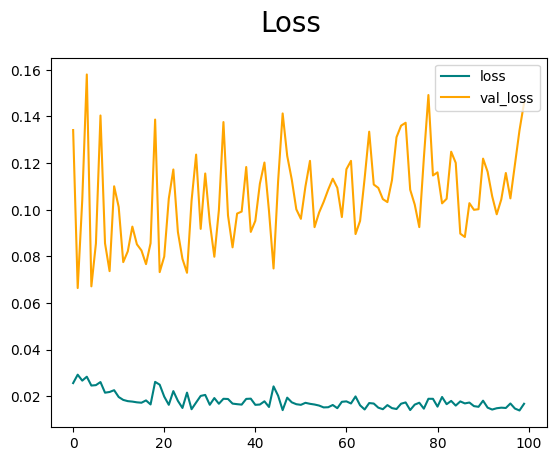

In [139]:
fig = plt.figure()
plt.plot(hist.history['loss'], label='loss', color='teal')
plt.plot(hist.history['val_loss'], label='val_loss', color='orange')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper right')
plt.show()

Evaluate Performance

Evaluate

In [140]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy #Import the metrics from keras

In [142]:
pre = Precision() #Create a precision metric
re = Recall() #Create a recall metric
acc = BinaryAccuracy() #Create a binary accuracy metric

In [144]:
for batch in test_data: #For each batch in the test data
    X_test, Y_test = batch #Get the images and labels from the batch
    Y_pred = model.predict(X_test) #Get the predictions from the model
    pre.update_state(Y_test, Y_pred) #Update the precision metric with the true labels and predicted labels
    re.update_state(Y_test, Y_pred) #Update the recall metric with the true labels and predicted labels
    acc.update_state(Y_test, Y_pred) #Update the accuracy metric with the true labels and predicted labels

1/1 [==============================] - 0s 246ms/step


In [145]:
print(f"Precision: {pre.result().numpy()}") #Print the precision metric
print(f"Recall: {re.result().numpy()}") #Print the recall metric
print(f"Accuracy: {acc.result().numpy()}") #Print the accuracy metric

Precision: 0.9375
Recall: 1.0
Accuracy: 0.96875


In [146]:
import cv2

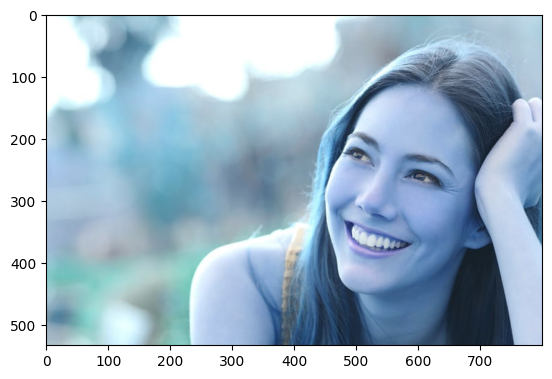

In [148]:
img = cv2.imread('happytest.jpg') #Read the image from the file
plt.imshow(img) #Show the image
plt.show()

In [ ]:
resize = tf.image.resize(img, (256, 256)) #Resize the image to (256, 256)
plt.imshow(resize.numpy().astype('int')) #Show the resized image
